# <font color='blue'> INITIALISATION </font> 
## <font color='green'> Import des packages </font> 

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings
from OutilsP5 import *

#SciKit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

#YellowBrick
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import intercluster_distance
from yellowbrick.cluster.elbow import kelbow_visualizer

In [2]:
# On ingnorera les warning concernant les prochaines versions
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## <font color='green'> Import des données </font> 

Lancer le notebook d'exploration afin d'obtenir le fichier modelData.csv & orders_view.csv.

In [3]:
orders_view = pd.read_csv('orders_view.csv')
data = pd.read_csv("modelData.csv")
data.set_index("customer_unique_id", inplace = True)
data.head(3)

,recency,frequency,monetary,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,130,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,19,4.0
0000f46a3911fa3c0805444483337064,541,1,69,3.0


In [4]:
normalizer = StandardScaler()
model_data = pd.DataFrame(normalizer.fit_transform(data), index = data.index, columns = data.columns)

# <font color='red'> I - Segmentation par RFM </font> 

In [5]:
RFM_data = data.loc[:,['recency','frequency','monetary']].copy()

n_bins = 5

RFM_data['recency_Q'] = pd.qcut(RFM_data['recency'],n_bins, labels = range(n_bins,0,-1))
RFM_data['frequency_Q'] = pd.cut(RFM_data['frequency'],n_bins, labels = range(1,n_bins+1))
RFM_data['monetary_Q'] = pd.qcut(RFM_data['monetary'],n_bins, labels = range(1,n_bins+1))
RFM_data = RFM_data.loc[:,['recency','recency_Q','frequency','frequency_Q','monetary','monetary_Q']]

RFM_data['recency_Q'] = RFM_data['recency_Q'].astype(int)
RFM_data['frequency_Q'] = RFM_data['frequency_Q'].astype(int)
RFM_data['monetary_Q'] = RFM_data['monetary_Q'].astype(int)

RFM_data.head(9)

,recency,recency_Q,frequency,frequency_Q,monetary,monetary_Q
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,4,1,1,130,4
0000b849f77a49e4a4ce2b2a4ca5be3f,118,4,1,1,19,1
0000f46a3911fa3c0805444483337064,541,1,1,1,69,2
0000f6ccb0745a6a4b88665a16c9f078,325,2,1,1,26,1
0004aac84e0df4da2b147fca70cf8255,292,2,1,1,180,4
0004bd2a26a76fe21f786e4fbd80607f,150,4,1,1,154,4
00050ab1314c0e55a6ca13cf7181fecf,135,4,1,1,28,1
00053a61a98854899e70ed204dd4bafe,186,3,1,1,382,5
0005e1862207bf6ccc02e4228effd9a0,547,1,1,1,135,4


In [6]:
print(RFM_data.loc[:,['recency','recency_Q']].groupby('recency_Q').describe().round(1),'\n\n')
print(RFM_data.loc[:,['frequency','frequency_Q']].groupby('frequency_Q').describe().round(2),'\n\n')
print(RFM_data.loc[:,['monetary','monetary_Q']].groupby('monetary_Q').describe().round(2), '\n\n')

           recency                                                
             count   mean   std    min    25%    50%    75%    max
recency_Q                                                         
1          18808.0  479.3  62.9  389.0  426.0  472.0  525.0  728.0
2          19006.0  321.4  35.4  273.0  286.0  318.0  352.0  388.0
3          18949.0  224.5  26.6  182.0  201.0  223.0  244.0  272.0
4          18996.0  139.7  23.8   97.0  118.0  139.0  161.0  181.0
5          18962.0   49.3  25.5    0.0   27.0   46.0   72.0   96.0 


            frequency                                           
                count   mean   std   min   25%   50%   75%   max
frequency_Q                                                     
1             94702.0   1.03  0.19   1.0   1.0   1.0   1.0   4.0
2                17.0   5.65  0.79   5.0   5.0   5.0   6.0   7.0
3                 1.0   9.00   NaN   9.0   9.0   9.0   9.0   9.0
5                 1.0  16.00   NaN  16.0  16.0  16.0  16.0  16.0 


   

,recency_Q,frequency_Q,monetary_Q
RFM_score,,,
3,1.000000,1.000000,1.000000
4,1.494082,1.000000,1.505918
5,2.056424,1.000085,1.943491
6,2.571098,1.000000,2.428902
7,3.048285,1.000000,2.951715
8,3.497806,1.000000,3.502194
9,4.000273,1.000000,3.999727
10,4.502843,1.000397,4.496761
11,4.997572,1.002428,5.000000


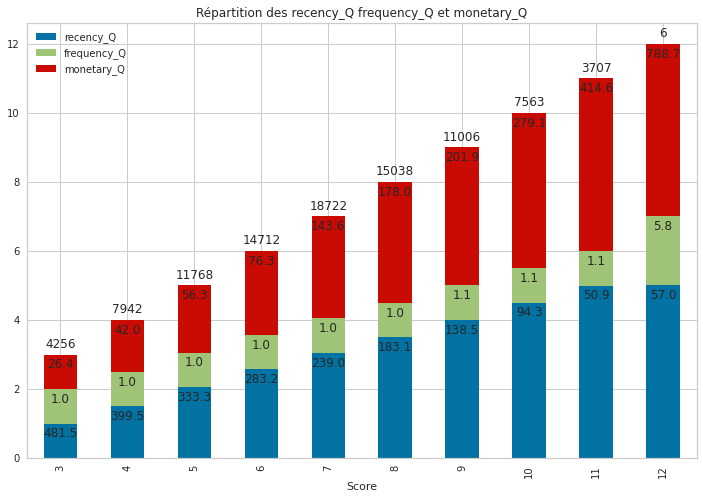

In [16]:
RFM_data['RFM_score'] = RFM_data['recency_Q'].astype(int) + RFM_data['frequency_Q'].astype(int) + RFM_data['monetary_Q'].astype(int)
RFM_data['recency_Q'] = RFM_data['recency_Q'].astype(int)
RFM_data['frequency_Q'] = RFM_data['frequency_Q'].astype(int)
RFM_data['monetary_Q'] = RFM_data['monetary_Q'].astype(int)
RFM_data.loc[:,['RFM_score','recency_Q','frequency_Q','monetary_Q']].groupby('RFM_score').mean().sort_index().drop(15).plot.bar(stacked = True, figsize = (12,8))
plt.title('Répartition des recency_Q frequency_Q et monetary_Q')
plt.xlabel('Score')

for a in RFM_data['RFM_score'].unique() :
    if a == 15 :
        continue
    Y1 = RFM_data.loc[RFM_data['RFM_score'] == a,'recency_Q'].mean()
    Y2 = Y1 + RFM_data.loc[RFM_data['RFM_score'] == a,'frequency_Q'].mean()
    Y3 = Y2 + RFM_data.loc[RFM_data['RFM_score'] == a,'monetary_Q'].mean()
    plt.text(a-3,a+0.2,str(RFM_data.loc[RFM_data['RFM_score'] == a,'RFM_score'].count()),horizontalalignment='center')
    plt.text(a-3,Y1-0.4,RFM_data.loc[RFM_data['RFM_score'] == a,'recency'].mean().round(1),horizontalalignment='center')
    plt.text(a-3,Y2-0.4,RFM_data.loc[RFM_data['RFM_score'] == a,'frequency'].mean().round(1),horizontalalignment='center')
    plt.text(a-3,Y3-0.4,RFM_data.loc[RFM_data['RFM_score'] == a,'monetary'].mean().round(1),horizontalalignment='center')
tempDF = RFM_data.loc[:,['RFM_score','recency_Q','frequency_Q','monetary_Q']].groupby('RFM_score').mean().sort_index()

tempDF

# <font color='red'> II - Etude du KMeans-clustering </font> 

### Méthode du coude

In [9]:
nclusters_list = range (2,10)
inertia_results = []
for i in nclusters_list :
    modelKMeans = KMeans(n_clusters = i)
    modelKMeans.fit(model_data)
    inertia_results.append(modelKMeans.inertia_)

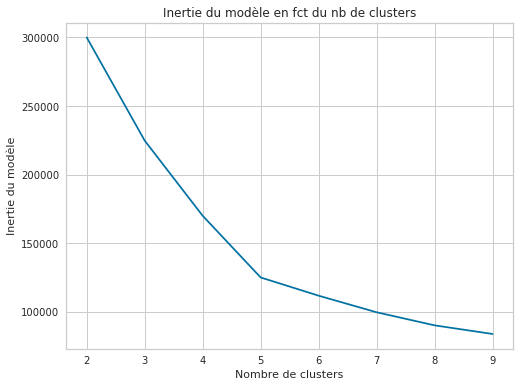

In [10]:
plt.figure(figsize = (8,6))
plt.plot(nclusters_list, inertia_results)
plt.title("Inertie du modèle en fct du nb de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie du modèle")
plt.show()

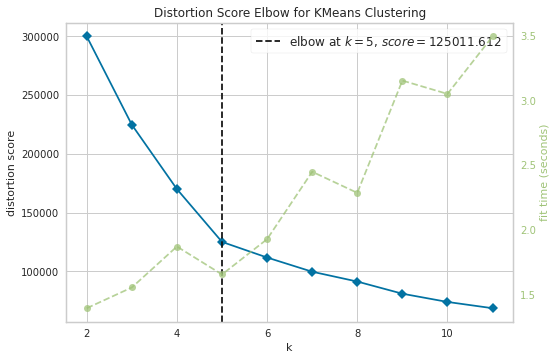

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=11, random_state=0), k=(2, 12))

In [13]:
kelbow_visualizer(KMeans(random_state = 0), model_data, k = (2,12))

On voit ici que le meilleur paramètre pour n_clusters est 5 d'après la règle du coude.

### Etudes des clusters générés

In [11]:
n_clusters = 5
modelKMeans = KMeans(n_clusters = n_clusters)
modelKMeans.fit(model_data)
print(f"L'inertie du modèle pour {n_clusters} clusters est de {int(modelKMeans.inertia_*1000)/1000}.")

L'inertie du modèle pour 5 clusters est de 125011.613.


In [12]:
KMeans_data = data.copy()
KMeans_data['label'] = modelKMeans.labels_
result_KMeans = KMeans_data.groupby("label").describe(percentiles = [0.5])
for e in [('recency', 'max'),('recency', 'std'),('frequency', 'count'),('frequency', 'min'),('frequency', 'std'),
          ('monetary', 'count'),('monetary', 'std'),('satisfaction', 'count'),('satisfaction', 'std')] :
    result_KMeans.drop(columns = e, inplace = True)
result_KMeans = result_KMeans.round(1)
result_KMeans

recency                      frequency            monetary         \
         count   mean    min    50%      mean  50%   max     mean    min   
label                                                                      
0      41805.0  126.1    4.0  123.0       1.0  1.0   1.0    111.8    1.0   
1      31609.0  397.3  260.0  387.0       1.0  1.0   1.0    113.6    2.0   
2       2013.0  243.7    5.0  224.0       1.0  1.0   4.0   1198.3  640.0   
3      16455.0  243.3    4.0  223.0       1.0  1.0   1.0    127.9    4.0   
4       2839.0  225.5    0.0  204.0       2.1  2.0  16.0    242.4   12.0   

                      satisfaction                 
         50%      max         mean  min  50%  max  
label                                              
0       82.0    699.0          4.7  3.0  5.0  5.0  
1       80.0    740.0          4.6  2.0  5.0  5.0  
2      987.0  13440.0          4.0  1.0  5.0  5.0  
3       90.0    759.0          1.6  1.0  1.0  3.0  
4      180.0   2200.0          4.1  1.0  4.5  5.0

<AxesSubplot:title={'center':'satisfaction'}, xlabel='label'>

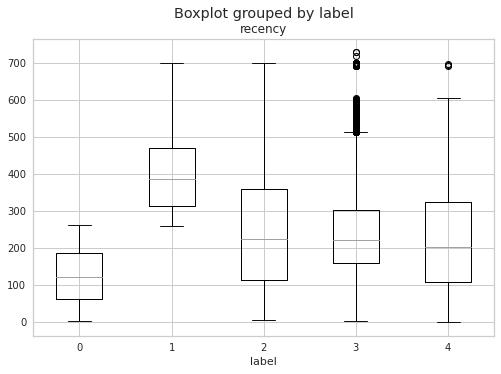

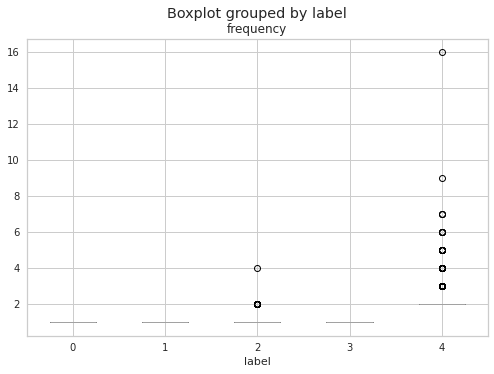

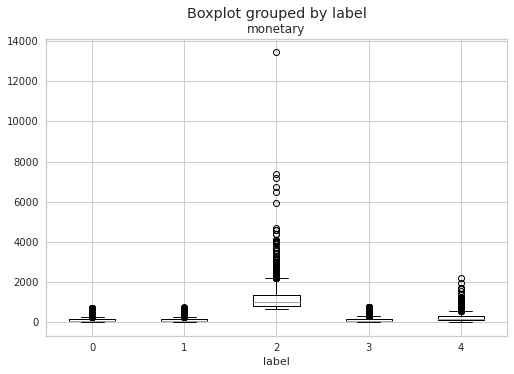

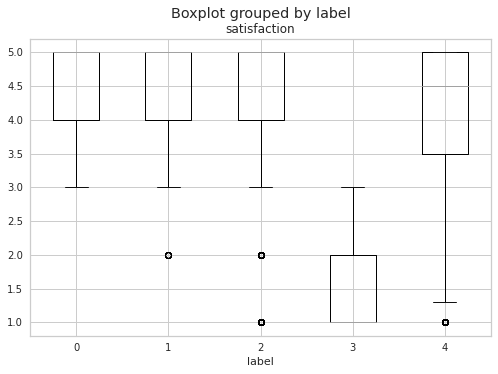

In [29]:
KMeans_data.boxplot(column = ['recency'], by = 'label')
KMeans_data.boxplot(column = ['frequency'], by = 'label')
KMeans_data.boxplot(column = ['monetary'], by = 'label')
KMeans_data.boxplot(column = ['satisfaction'], by = 'label')

0.4198458651593225


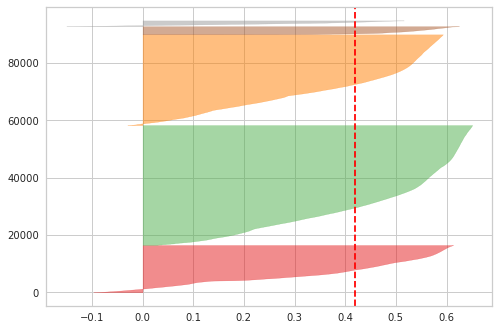

In [12]:
visualizer = SilhouetteVisualizer(modelKMeans)
visualizer.fit(model_data)
print(visualizer.silhouette_score_)

### Distance inter cluster

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


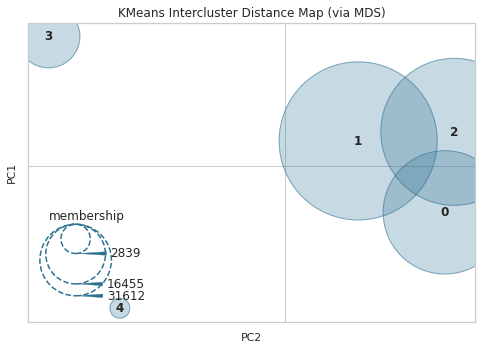

In [14]:
visualizer = intercluster_distance(modelKMeans, model_data)

### Application du contrat de maintenance au K-means

70
140
210
280
350


Text(0, 0.5, 'Performance conservée')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


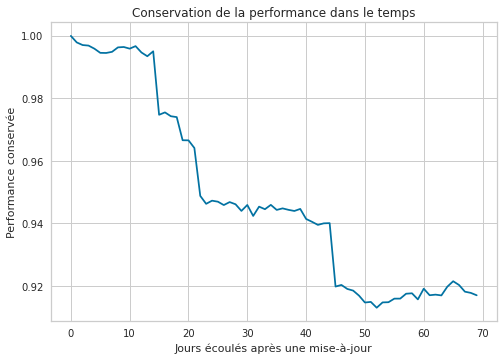

In [6]:
all_X = []
all_Y = []

for j in  [70,140,210,280,350] :
    print(j)
    X = []
    Y = []
    orders_view['purchase_date'] = pd.to_datetime(orders_view['purchase_date'], format = "%Y-%m-%d %H:%M:%S")
    today = orders_view["purchase_date"].max()
    maj_date = today-dt.timedelta(days = j)
    old_data, customers_list = timeCut(orders_view, end_date = maj_date)

    # Prédiction des nouveaux clients sur la base des données précédentes
    oldModelKMeans = KMeans(n_clusters = 5)
    old_model_data = pd.DataFrame(normalizer.fit_transform(old_data), index = old_data.index, columns = old_data.columns)
    oldModelKMeans.fit(old_model_data)


    for i in range(70) :
        new_data, customers_list = timeCut(orders_view, end_date = maj_date + dt.timedelta(days = i))
        new_model_data = normalizer.fit_transform(new_data)
        kmeans_prediction = oldModelKMeans.predict(new_model_data)
    
        # Prédiction des nouveaux clients sur la base de données mise-à-jour
        new_model_data = pd.DataFrame(normalizer.fit_transform(new_data), index = new_data.index, columns = new_data.columns)
        newModelKMeans = KMeans(n_clusters = 5)
        newModelKMeans.fit(new_model_data)
    
        df = new_model_data.copy()
        df['label'] = newModelKMeans.labels_
        df['predicted_label'] = kmeans_prediction
        X.append(i)
        Y.append(adjusted_rand_score(df['label'], df['predicted_label']))
    
    all_X.append(X)
    all_Y.append(Y)
X_df = pd.DataFrame(all_X)
Y_df = pd.DataFrame(all_Y)
plt.plot(X_df.mean(axis = 0),Y_df.mean(axis = 0))
plt.title("Conservation de la performance dans le temps")
plt.xlabel("Jours écoulés après une mise-à-jour")
plt.ylabel("Performance conservée")

Text(0, 0.5, 'Performance conservée')

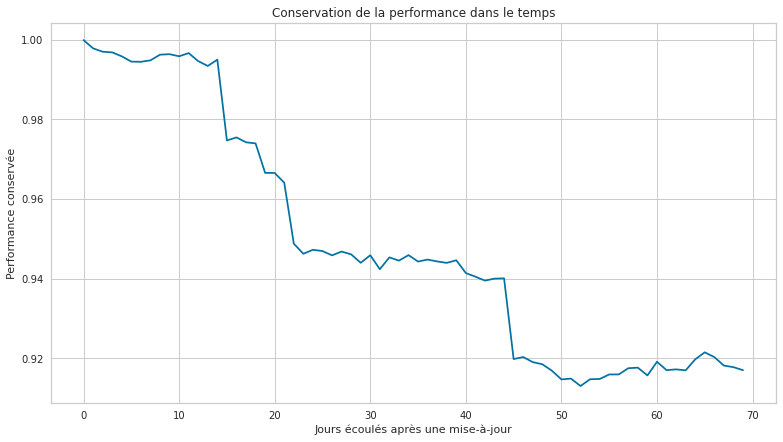

In [8]:
plt.figure(figsize = (13,7))
plt.plot(X_df.mean(axis = 0),Y_df.mean(axis = 0))
plt.title("Conservation de la performance dans le temps")
plt.xlabel("Jours écoulés après une mise-à-jour")
plt.ylabel("Performance conservée")

# <font color='red'> III - Etude du Agglomerative Clustering  </font> 

Cet Algorithme est gourmand en mémoire (33 Gb de RAM necessaire pour faire passer les 94721 clients), on s'attaquera donc à un échantillon de 40k individus choisis au hasard.

In [5]:
entry_index = np.random.choice(data.index, size = 40000, replace = False).tolist()
temp_data = data.loc[entry_index,:]
modelAgglomerative = AgglomerativeClustering(n_clusters = 5,  affinity='euclidean')
modelAgglomerative.fit(normalizer.fit_transform(temp_data))

AgglomerativeClustering(n_clusters=5)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


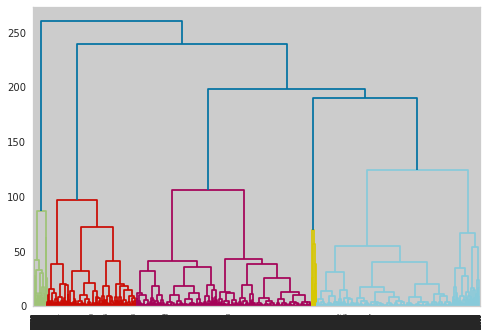

In [5]:
entry_index = np.random.choice(data.index, size = 40000, replace = False).tolist()
temp_data = data.loc[entry_index,:]
modelAgglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
modelAgglomerative = modelAgglomerative.fit(normalizer.fit_transform(temp_data))
plot_dendrogram(modelAgglomerative)

In [71]:
temp_data.head(4)<

,recency,frequency,monetary,satisfaction
customer_unique_id,,,,
07df139093b720d6512c49da2980e3ee,548,1,35,4.0
616ec2f13ea3c1ec4582808ab05f3251,524,1,299,4.0
30b6fe5fb355877c7bded1817219d96c,272,1,90,3.0
4be8c45afe1594717006af8bb96a4ff0,318,1,199,5.0


In [74]:
score_test = []
for e in range(10) :
    entry_index = np.random.choice(data.index, size = 40000, replace = False).tolist()
    temp_data = data.loc[entry_index,:]
    modelAgglomerative = AgglomerativeClustering(n_clusters = 5,  affinity='euclidean')
    modelAgglomerative.fit(normalizer.fit_transform(temp_data))
    score_test.append(silhouette_score(normalizer.fit_transform(temp_data), modelAgglomerative.labels_))


print(np.array(score_test).round(3))

[0.377 0.383 0.381 0.363 0.419 0.415 0.381 0.358 0.379 0.355]


Les scores de silhouette sont inférieur au résultats du K-Means clustering. On s'attardera donc plus longtemps sur le K-Means.

# <font color='red'> IV - Etude du DBSCAN </font> 

In [23]:
modelDBSCAN = DBSCAN(eps = 0.25, min_samples=1000)
modelDBSCAN.fit(model_data)

DBSCAN(eps=0.25, min_samples=1000)

In [24]:
DBSCAN_data = data.copy()
DBSCAN_data['label'] = modelDBSCAN.labels_
result_DBSCAN = DBSCAN_data.groupby("label").describe(percentiles = [0.5])
for e in [('recency', 'max'),('recency', 'std'),('frequency', 'count'),('frequency', 'min'),('frequency', 'std'),
          ('monetary', 'count'),('monetary', 'std'),('satisfaction', 'count'),('satisfaction', 'std')] :
    result_DBSCAN.pop(e)
result_DBSCAN = result_DBSCAN.round(1)
result_DBSCAN

recency                      frequency            monetary              \
         count   mean    min    50%      mean  50%   max     mean  min    50%   
label                                                                           
-1     33189.0  277.5    0.0  272.0       1.1  1.0  16.0    252.3  4.0  163.0   
 0     46712.0  233.2    4.0  216.0       1.0  1.0   1.0     85.8  1.0   71.0   
 1     12047.0  195.1    5.0  189.0       1.0  1.0   1.0     73.3  1.0   66.0   
 2      2773.0  183.5  111.0  184.0       1.0  1.0   1.0     74.1  4.0   70.0   

               satisfaction                 
           max         mean  min  50%  max  
label                                       
-1     13440.0          3.1  1.0  3.0  5.0  
 0       265.0          5.0  5.0  5.0  5.0  
 1       187.0          4.0  4.0  4.0  4.0  
 2       166.0          1.0  1.0  1.0  1.0

In [25]:
silhouette_score(model_data, modelDBSCAN.labels_)

-0.002035432799323578

### Optimisation des hyperparamètres eps et n_sample

In [26]:
params = {'eps' : [0.05,0.07,0.09,0.1,0.14],
          'min_samples' : [30,60,100,200,300,500]}
cv_results = []

In [27]:
for e1 in params["eps"] :
    for e2 in params['min_samples'] :
        modelDBSCAN = DBSCAN(eps = e1, min_samples=e2)
        modelDBSCAN.fit(model_data)
        try :
            cv_results.append([e1,e2,silhouette_score(model_data, modelDBSCAN.labels_)])
        except :
            cv_results.append([e1,e2,np.nan])

In [ ]:
cv_results = pd.DataFrame(cv_results, columns = ['eps','min_samples','silhouette_score'])
cv_results

,eps,min_samples,silhouette_score
0,0.05,30,-0.375556
1,0.05,60,-0.467697
2,0.05,100,-0.389420
3,0.05,200,-0.334004
4,0.05,300,-0.372475
5,0.05,500,NaN
6,0.07,30,-0.224662
7,0.07,60,-0.235544
8,0.07,100,-0.422216
9,0.07,200,-0.329928


In [ ]:
params = {'eps' : [0.2,0.3,0.4,0.5],
          'min_samples' : [100,200,300,500]}
cv_results = []

for e1 in params["eps"] :
    for e2 in params['min_samples'] :
        modelDBSCAN = DBSCAN(eps = e1, min_samples=e2)
        modelDBSCAN.fit(model_data)
        try :
            cv_results.append([e1,e2,silhouette_score(model_data, modelDBSCAN.labels_)])
        except :
            cv_results.append([e1,e2,np.nan])

In [29]:
print(cv_results['silhouette_score'].max())
print(cv_results['silhouette_score'].min())
print(cv_results['silhouette_score'].mean())

0.07664821800010281
-0.4676972787647221
-0.16313082180094046


Les résultats du DBSCAN sont absoluement irrecevable, on ne creusera pas plus loin pour cet algorithme